In [70]:
import matplotlib.pyplot as plt
import numpy as np

In [71]:
class GaussianBeam:
    def __init__(self, wavelength, w0, A0):
        self.wavelength = wavelength
        self.w0 = w0
        self.A0 = A0

    def z0(self):
        return np.pi*self.w0**2/self.wavelength

    def w(self, z):   
        return self.w0*np.sqrt(1+(z/self.z0())**2)
        
    def R(self, z):
        return z*(1+(self.z0()/(z + 1e-15))**2)
        
    def zeta(self, z):
        return np.arctan(z/self.z0())

    def wavefunction(self, x, y, z):
        rho = np.sqrt(x**2 + y**2)
        A0 = self.A0
        w0 = self.w0
        w = self.w(z)
        k = 2*np.pi/self.wavelength
        R = self.R(z)
        zeta = self.zeta(z)
        return A0*(w0/w)*np.exp(-rho**2/(w**2 + 1e-15))*np.exp(-1j*k*(rho**2)/(2*R + 1e-15))*np.exp(1j*zeta)

    def wavefunction_in_0(self, x, y):
        A0 = self.A0
        w0 = self.w0
        return A0*np.exp(-(x**2+y**2)/w0**2 + 1e-15)

    def intensity(self, x, y, z):
        return np.abs(self.wavefunction(x, y, z))**2
                  

In [72]:
wavelength = 0.6328e-6
w0 = 1e-3
A0 = 1
beam = GaussianBeam(wavelength, w0, A0)


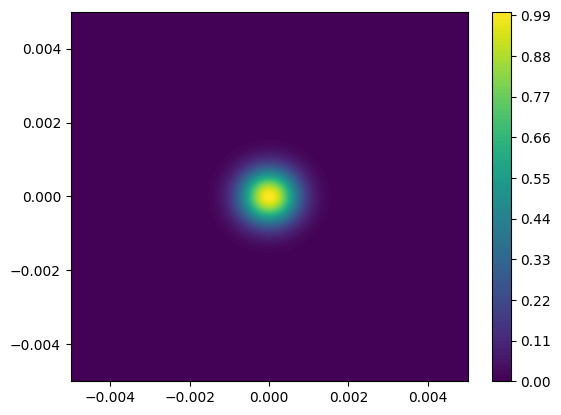

In [73]:
Nx = 512
Ny = 512
Lx = 1e-2
Ly = 1e-2
x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)

X, Y = np.meshgrid(x, y)
wavefunction = beam.wavefunction_in_0(X, Y)
# intensity = beam.intensity(X, Y, 0)

# Contour plot
plt.figure()
plt.contourf(X, Y, np.abs(wavefunction)**2, 100)
plt.colorbar()

512
9929180.321080256


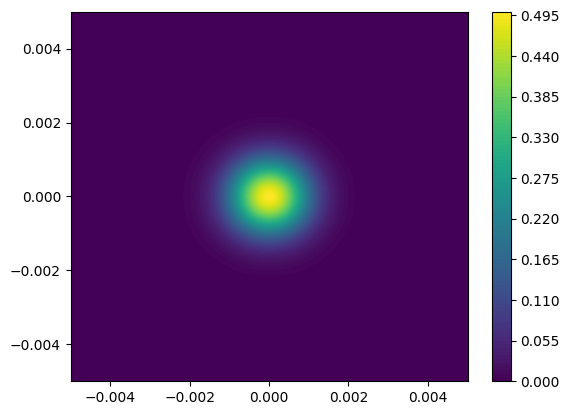

In [74]:
intfft = np.fft.fft2(wavefunction)
print(intfft.shape[1])

freq_x = 2*np.pi*np.fft.fftfreq(Nx, Lx/Nx)
freq_y = 2*np.pi*np.fft.fftfreq(Ny, Ly/Ny)
freq_X, freq_Y = np.meshgrid(freq_x, freq_y)

wavelength = beam.wavelength
k = 2*np.pi/wavelength

print(k)
z = beam.z0() 
distprop = np.exp(-1j * k * z * np.sqrt(1 - (wavelength**2 * freq_X**2 + wavelength**2 * freq_Y**2) / (4 * np.pi**2)))

intfftprop = intfft * distprop
wavefunctionprop = np.fft.ifft2(intfftprop)


# Contour plot
plt.figure()
plt.contourf(X, Y, np.abs(wavefunctionprop)**2, 100)
plt.colorbar()

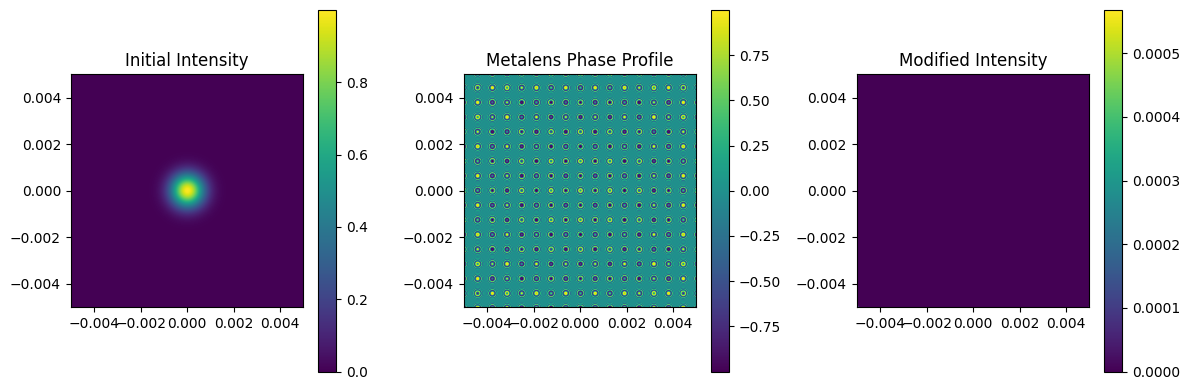

In [75]:
class Metalens:
    def __init__(self, f, wavelength):
        self.f = f  # focal length of the metalens
        self.wavelength = wavelength

    def phase_profile(self, x, y):
        k = 2 * np.pi / self.wavelength
        return np.sin(k * (x**2 + y**2) / (2 * self.f))

#Define the Gaussian beam
wavelength = 0.6328e-6  # Wavelength in meters (example: 632.8 nm)
w0 = 0.001  # Beam waist in meters
A0 = 1.0  # Amplitude

gaussian_beam = GaussianBeam(wavelength, w0, A0)

# Define the metalens
focal_length = 0.02  # Focal length of the metalens in meters
metalens = Metalens(focal_length, wavelength)

# Generate a grid of points
x_range = np.linspace(-0.005, 0.005, 500)
y_range = np.linspace(-0.005, 0.005, 500)
x, y = np.meshgrid(x_range, y_range)

# Get the initial wavefunction at z=0
initial_wavefunction = gaussian_beam.wavefunction_in_0(x, y)

# Get the phase profile from the metalens
phase_profile = metalens.phase_profile(x, y)

# Apply the phase profile in the Fourier domain
modified_wavefunction_fft = initial_wavefunction * np.exp(1j * phase_profile)

# Perform an inverse Fourier transform to get the modified wavefunction
modified_wavefunction = np.fft.fftshift(np.fft.ifft2(modified_wavefunction_fft))
modified_wavefunction = np.fft.ifft2(modified_wavefunction_fft)

# Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(np.abs(initial_wavefunction)**2, extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Initial Intensity')
plt.colorbar()

plt.subplot(132)
plt.imshow(phase_profile, extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Metalens Phase Profile')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.abs(modified_wavefunction)**2, extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Modified Intensity')
plt.colorbar()

plt.tight_layout()
plt.show()

In [76]:
class MetalensGrid:
    def __init__(self, f, wavelength, num_points):
        self.f = f  # focal length of the metalens
        self.wavelength = wavelength
        self.num_points = num_points
        self.phase_grid = self._generate_phase_grid()

    def _generate_phase_grid(self):
        x_range = np.linspace(-0.005, 0.005, self.num_points)
        y_range = np.linspace(-0.005, 0.005, self.num_points)
        x, y = np.meshgrid(x_range, y_range)
        k = 2 * np.pi / self.wavelength
        #grid = np.sin(x)
        #grid  = k * (x**2 + y**2) / (2 * self.f)
        grid = k * (y-x)
        return grid

    def get_phase_profile(self):
        phase_profile = np.zeros((self.num_points, self.num_points), dtype=np.complex128)

        for i in range(self.num_points):
            for j in range(self.num_points):
                phase_profile[i, j] = np.exp(1j * self.phase_grid[i, j])
        
        return phase_profile
    
    def get_phase_profile2(self, radius):
        phase_profile = np.zeros((self.num_points, self.num_points), dtype=np.complex128)
        for i in range(self.num_points):
            for j in range(self.num_points): 
                distance = np.sqrt((i - self.num_points // 2)**2 + (j - self.num_points // 2)**2)
                if distance <= radius:
                    # Sinusoidal phase profile for a fun effect
                    phase = np.sin(2 * np.pi * distance / wavelength)
                    phase_profile[i, j] = np.exp(1j * phase)
        return phase_profile


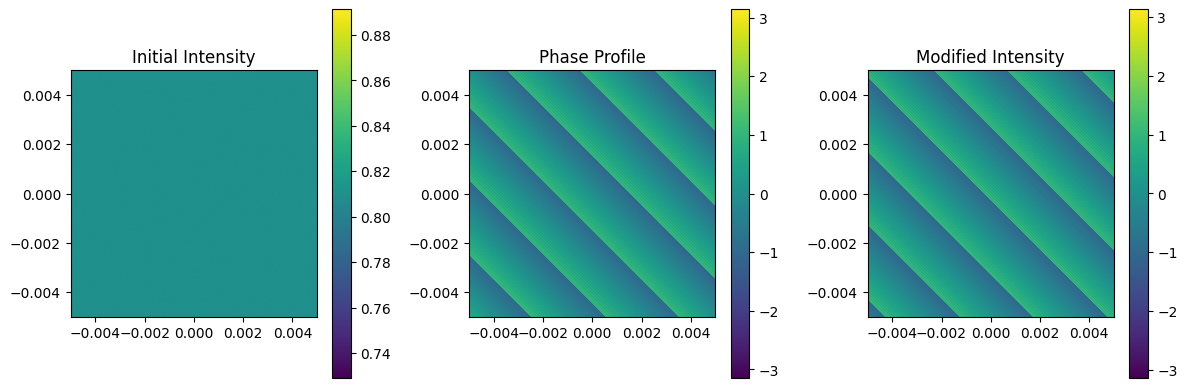

In [77]:
metalens = MetalensGrid(focal_length, wavelength, 500)
phase_profile = metalens.get_phase_profile()

# Gaussian beam
wavelength = 0.6328e-6  # Wavelength in meters (example: 632.8 nm)
w0 = 0.001  # Beam waist in meters
A0 = 1.0  # Amplitude

gaussian_beam = GaussianBeam(wavelength, w0, A0)

# Generate a grid of points
x_range = np.linspace(-0.005, 0.005, 500)
y_range = np.linspace(-0.005, 0.005, 500)
x, y = np.meshgrid(x_range, y_range)

# Get the initial wavefunction at z=0
initial_wavefunction = gaussian_beam.wavefunction_in_0(x, y) * np.exp(2j * np.pi / wavelength)

wf = initial_wavefunction * phase_profile

# Plot the phase profile of the metalens and the gaussian beam
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(np.angle(initial_wavefunction), extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Initial Intensity')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.angle(phase_profile), extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Phase Profile')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.angle(wf), extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Modified Intensity')
plt.colorbar()

plt.tight_layout()
plt.show()


In [78]:
class MetalensGrid:
    def __init__(self, focal_length, wavelength, num_points):
        self.focal_length = focal_length
        self.wavelength = wavelength
        self.num_points = num_points

    def get_phase_profile(self):
        # Create a grid of points
        x_range = np.linspace(-0.005, 0.005, self.num_points)
        y_range = np.linspace(-0.005, 0.005, self.num_points)
        x, y = np.meshgrid(x_range, y_range)

        # Calculate the phase at each point
        phase = np.cos((x**2 + y**2))

        # Return the phase profile
        return np.exp(1j*phase)


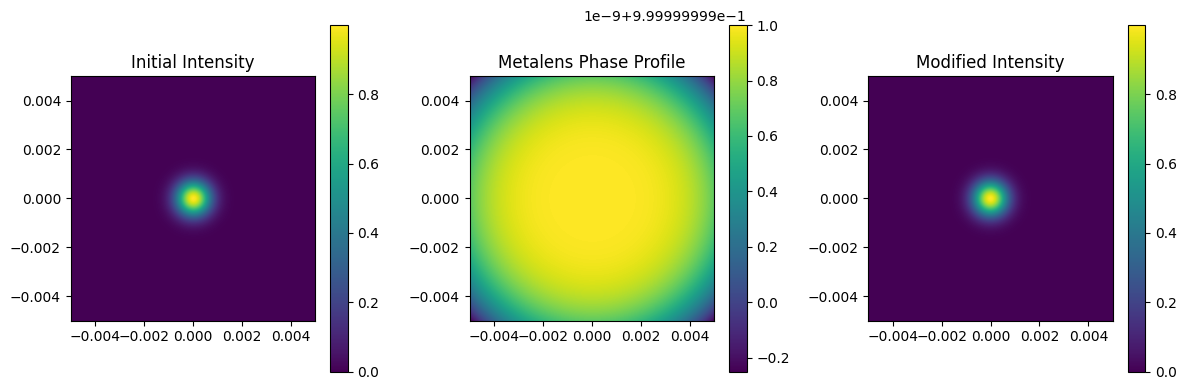

In [79]:
wavelength = 0.6328e-6  # Wavelength in meters (example: 632.8 nm)
w0 = 0.001  # Beam waist in meters
A0 = 1.0  # Amplitude

gaussian_beam = GaussianBeam(wavelength, w0, A0)

# Create a metalens
metalens = MetalensGrid(focal_length, wavelength, 500)
phase_profile = metalens.get_phase_profile()

# Generate a grid of points
x_range = np.linspace(-0.005, 0.005, 500)
y_range = np.linspace(-0.005, 0.005, 500)
x, y = np.meshgrid(x_range, y_range)

# Get the initial wavefunction at z=0
initial_wavefunction = gaussian_beam.wavefunction_in_0(x, y) * np.exp(2j * np.pi / wavelength)

wf_fft = np.fft.fft2(initial_wavefunction * phase_profile)
# Apply the phase profile in the Fourier domain
modified_wavefunction_fft = wf_fft

# Perform an inverse Fourier transform to get the modified wavefunction
modified_wavefunction = np.fft.ifft2(modified_wavefunction_fft)

# Plot the phase profile of the metalens and the gaussian beam
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(np.abs(initial_wavefunction)**2, extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Initial Intensity')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.angle(phase_profile), extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Metalens Phase Profile')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.abs(modified_wavefunction)**2, extent=(x.min(), x.max(), y.min(), y.max()), cmap='viridis')
plt.title('Modified Intensity')
plt.colorbar()

plt.tight_layout()
plt.show()
